Enet: https://github.com/BBuf/ENet-Keras/blob/master/train.py

In [1]:
# Initialisation of libraries/directories
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Img
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

from keras.models import *
from keras.layers import *

%matplotlib inline

Using TensorFlow backend.


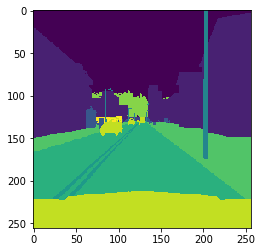

In [22]:
img=cv2.imread('/jet/prs/workspace/Data/Mask_data/MD/04_00_000.png') 
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)[:,:,2]
plt.imshow(img)

In [2]:
# Reading Mask Images
files=list(os.walk('/jet/prs/workspace/Data/Mask_data/MD/'))[0][2]
mask_img=[]

for i in range(len(files)):
    mask_img.append(cv2.imread('/jet/prs/workspace/Data/Mask_data/MD/'+str(files[i]))[:,:,2])

In [3]:
a = np.array(mask_img)

In [4]:
labels = list(np.unique(mask_img))
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [5]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

In [6]:
# My try Data Augmentation
import numpy as np
import cv2
import glob
import itertools
def generator(image_path, mask_path, batch_size, input_height, input_width, labels):
    
    assert image_path[-1] == '/'
    assert mask_path[-1] == '/'
    
    images = glob.glob( image_path + "*.png"  ) 
    images.sort()
    segmentations  = glob.glob( mask_path + "*.png"  )
    segmentations.sort()
    
    #no of images in both folders is same
    assert len( images ) == len(segmentations)
    
    #Files are in correspondance
    for im , seg in zip(images,segmentations):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
        
    zipped = itertools.cycle( zip(images,segmentations) )
    
    while True:
        X = []
        Y = []
        for _ in range(batch_size) :
            im , seg = next(zipped)
            
            img = cv2.imread(im)[:,:,::-1]
            img = image_datagen.random_transform(img, seed=1)
            img = img.astype(np.float32)
            img = img/255.0
            img = cv2.resize(img, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)
            
            
            X.append(img)
            
            img1 = cv2.imread(seg)
            img1 = image_datagen.random_transform(img1, seed=1)
            img1 = cv2.resize(img1, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)[:,:,2]
#             img1 = image_datagen.random_transform(img1, seed=1)
            
            seg_labels = np.zeros((  input_height , input_width  , len(labels)))
            
            
            
            
            for c,l in enumerate(labels):
                seg_labels[: , : , c ] = ((img1 == l))*1
            
            seg_labels = seg_labels.astype(np.float32)
#             seg_labels = np.reshape(seg_labels, ( input_height,input_width , len(labels) ))
               
            Y.append(seg_labels)
            

        yield np.array(X) , np.array(Y)
    

In [7]:
a = generator('/jet/prs/workspace/Data/Raw_Data/RD/' , '/jet/prs/workspace/Data/Mask_data/MD/', 1000, 256,256,labels)

In [8]:
b,c =next(a)

In [9]:
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.engine.topology import Input
from keras.models import Model

In [10]:
def initial_block(inp, nb_filter=13, nb_row=3, nb_col=3, strides=(2, 2)):
    conv = Conv2D(nb_filter, (nb_row, nb_col), padding='same', strides=strides)(inp)
    max_pool = MaxPooling2D()(inp)
    merged = concatenate([conv, max_pool], axis=3)
    return merged

def bottleneck(inp, output, internal_scale=4, asymmetric=0, dilated=0, downsample=False, dropout_rate=0.1):
    # main branch
    internal = output // internal_scale
    encoder = inp
    # 1x1
    input_stride = 2 if downsample else 1  # the 1st 1x1 projection is replaced with a 2x2 convolution when downsampling
    encoder = Conv2D(internal, (input_stride, input_stride),
                     # padding='same',
                     strides=(input_stride, input_stride), use_bias=False)(encoder)
    # Batch normalization + PReLU
    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = PReLU(shared_axes=[1, 2])(encoder)

    # conv
    if not asymmetric and not dilated:
        encoder = Conv2D(internal, (3, 3), padding='same')(encoder)
    elif asymmetric:
        encoder = Conv2D(internal, (1, asymmetric), padding='same', use_bias=False)(encoder)
        encoder = Conv2D(internal, (asymmetric, 1), padding='same')(encoder)
    elif dilated:
        encoder = Conv2D(internal, (3, 3), dilation_rate=(dilated, dilated), padding='same')(encoder)
    else:
        raise (Exception('You shouldn\'t be here'))

    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = PReLU(shared_axes=[1, 2])(encoder)

    # 1x1
    encoder = Conv2D(output, (1, 1), use_bias=False)(encoder)

    encoder = BatchNormalization(momentum=0.1)(encoder)  # enet uses momentum of 0.1, keras default is 0.99
    encoder = SpatialDropout2D(dropout_rate)(encoder)

    other = inp
    # other branch
    if downsample:
        other = MaxPooling2D()(other)

        other = Permute((1, 3, 2))(other)
        pad_feature_maps = output - inp.get_shape().as_list()[3]
        tb_pad = (0, 0)
        lr_pad = (0, pad_feature_maps)
        other = ZeroPadding2D(padding=(tb_pad, lr_pad))(other)
        other = Permute((1, 3, 2))(other)

    encoder = add([encoder, other])
    encoder = PReLU(shared_axes=[1, 2])(encoder)

    return encoder

def en_build(inp, dropout_rate=0.01):
    enet = initial_block(inp)
    enet = BatchNormalization(momentum=0.1)(enet)  # enet_unpooling uses momentum of 0.1, keras default is 0.99
    enet = PReLU(shared_axes=[1, 2])(enet)
    enet = bottleneck(enet, 64, downsample=True, dropout_rate=dropout_rate)  # bottleneck 1.0
    for _ in range(4):
        enet = bottleneck(enet, 64, dropout_rate=dropout_rate)  # bottleneck 1.i

    enet = bottleneck(enet, 128, downsample=True)  # bottleneck 2.0
    # bottleneck 2.x and 3.x
    for _ in range(2):
        enet = bottleneck(enet, 128)  # bottleneck 2.1
        enet = bottleneck(enet, 128, dilated=2)  # bottleneck 2.2
        enet = bottleneck(enet, 128, asymmetric=5)  # bottleneck 2.3
        enet = bottleneck(enet, 128, dilated=4)  # bottleneck 2.4
        enet = bottleneck(enet, 128)  # bottleneck 2.5
        enet = bottleneck(enet, 128, dilated=8)  # bottleneck 2.6
        enet = bottleneck(enet, 128, asymmetric=5)  # bottleneck 2.7
        enet = bottleneck(enet, 128, dilated=16)  # bottleneck 2.8

    return enet

# decoder
def de_bottleneck(encoder, output, upsample=False, reverse_module=False):
    internal = output // 4

    x = Conv2D(internal, (1, 1), use_bias=False)(encoder)
    x = BatchNormalization(momentum=0.1)(x)
    x = Activation('relu')(x)
    if not upsample:
        x = Conv2D(internal, (3, 3), padding='same', use_bias=True)(x)
    else:
        x = Conv2DTranspose(filters=internal, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization(momentum=0.1)(x)
    x = Activation('relu')(x)

    x = Conv2D(output, (1, 1), padding='same', use_bias=False)(x)

    other = encoder
    if encoder.get_shape()[-1] != output or upsample:
        other = Conv2D(output, (1, 1), padding='same', use_bias=False)(other)
        other = BatchNormalization(momentum=0.1)(other)
        if upsample and reverse_module is not False:
            other = UpSampling2D(size=(2, 2))(other)

    if upsample and reverse_module is False:
        decoder = x
    else:
        x = BatchNormalization(momentum=0.1)(x)
        decoder = add([x, other])
        decoder = Activation('relu')(decoder)

    return decoder

def de_build(encoder, nc):
    enet = de_bottleneck(encoder, 64, upsample=True, reverse_module=True)  # bottleneck 4.0
    enet = de_bottleneck(enet, 64)  # bottleneck 4.1
    enet = de_bottleneck(enet, 64)  # bottleneck 4.2
    enet = de_bottleneck(enet, 16, upsample=True, reverse_module=True)  # bottleneck 5.0
    enet = de_bottleneck(enet, 16)  # bottleneck 5.1

    enet = Conv2DTranspose(filters=nc, kernel_size=(2, 2), strides=(2, 2), padding='same')(enet)
    return enet

def ENet(n_classes, input_height=512, input_width=512):
    assert input_height % 32 == 0
    assert input_width % 32 == 0
    img_input = Input(shape=(input_height, input_width, 3))
    enet = en_build(img_input)
    enet = de_build(enet, n_classes)
    o_shape = Model(img_input, enet).output_shape
    outputHeight = o_shape[1]
    outputWidth = o_shape[2]
    enet = (Reshape((outputHeight, outputWidth, n_classes)))(enet)
    enet = Activation('softmax')(enet)
    model = Model(img_input, enet)
    print(outputHeight)
    print(outputWidth)
    model.outputWidth = outputWidth
    model.outputHeight = outputHeight

    return model

In [11]:
model = ENet(12, 256, 256)

256
256


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 128, 16) 0           conv2d_1[0][0]                   
                                                                 max_pooling2d_1[0][0]            
__________

In [15]:
from keras.optimizers import Adam, RMSprop 
from keras.metrics import categorical_crossentropy



#model_dice = dice_loss(smooth=1e-5, thresh=0.5)

model.compile(loss='categorical_crossentropy', optimizer= Adam(lr=0.001) , metrics=['accuracy'] )

In [16]:
history = model.fit_generator( a , 1000  , epochs=5 )
model.save('model_enet.h5')

Epoch 1/5


InternalError: Dst tensor is not initialized.
	 [[Node: _arg_input_1_0_0/_6189 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_35290__arg_input_1_0_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: loss_1/mul/_6395 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_35981_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

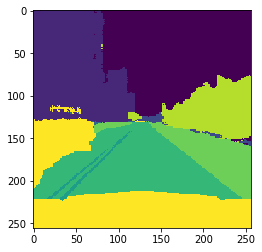

In [64]:
pr = model.predict(b)[4]
pr = pr.reshape(( 256 ,  256 , 12 ) ).argmax( axis=2 )
plt.imshow(pr)

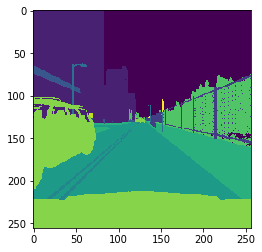

In [50]:
plt.imshow( c[0].reshape(( 256 ,  256 , 12 ) ).argmax( axis=2 ))

In [51]:
d = c[0].reshape(( 256 ,  256 , 12 ) ).argmax( axis=2 )

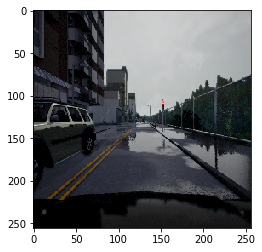

In [66]:
plt.imshow(b[4])

In [44]:
import random
colors = [  ( random.randint(0,255),random.randint(0,255),random.randint(0,255)   ) for _ in range(12)  ]


In [47]:
seg = pr

In [48]:
		seg_img = np.zeros( [256,256,3] )

		for c in range(12):
			seg_img[:,:,0] += ( (seg[:,:] == c )*( colors[c][0] )).astype('uint8')
			seg_img[:,:,1] += ((seg[:,:] == c )*( colors[c][1] )).astype('uint8')
			seg_img[:,:,2] += ((seg[:,:] == c )*( colors[c][2] )).astype('uint8')
		plt.imshow(seg_img.astype(int) )

ValueError: operands could not be broadcast together with shapes (256,256) (256,256,12) (256,256) 

In [62]:
seg = d

In [41]:
		seg_img = np.zeros( [256,256,3] )

		for c in range(12):
			seg_img[:,:,0] += ( (seg[:,:] == c )*( colors[c][0] )).astype('uint8')
			seg_img[:,:,1] += ((seg[:,:] == c )*( colors[c][1] )).astype('uint8')
			seg_img[:,:,2] += ((seg[:,:] == c )*( colors[c][2] )).astype('uint8')
		plt.imshow(seg_img.astype(int) )

NameError: name 'seg' is not defined

In [9]:
model = load_model('model_enet.h5')

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 128, 16) 0           conv2d_1[0][0]                   
                                                                 max_pooling2d_1[0][0]            
__________

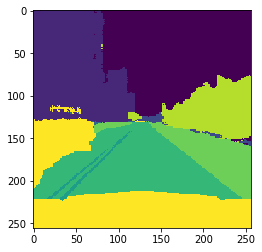

In [29]:
pr = model.predict(b)[4]
pr = pr.reshape(( 256 ,  256 , 12 ) ).argmax( axis=2 )
plt.imshow(pr)

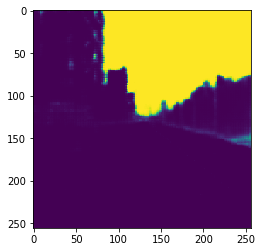

In [36]:
pr = model.predict(b)[4]
pr=pr.reshape(( 256 ,  256 , 12 ) )
plt.imshow(pr[:,:,0])

In [40]:
pr[:,:,0]

array([[  3.04078255e-02,   1.77265517e-02,   4.05973531e-02, ...,
          9.99682665e-01,   9.98936236e-01,   9.98281360e-01],
       [  1.74933225e-02,   1.07775088e-02,   1.96096823e-02, ...,
          9.99600708e-01,   9.98173952e-01,   9.96921301e-01],
       [  5.67265647e-03,   4.00598673e-03,   7.71665433e-03, ...,
          9.99959469e-01,   9.99552429e-01,   9.99100089e-01],
       ..., 
       [  1.62192402e-04,   9.18467995e-05,   6.66338224e-07, ...,
          1.12661346e-05,   3.73558869e-05,   2.18300193e-05],
       [  3.89734562e-03,   2.05596443e-03,   3.59164042e-05, ...,
          2.94087804e-04,   1.94749259e-03,   1.42309139e-03],
       [  7.01746962e-04,   4.75874112e-04,   4.94772939e-06, ...,
          1.35240800e-04,   1.03689684e-03,   7.38672155e-04]], dtype=float32)

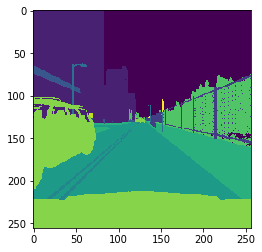

In [30]:
plt.imshow( c[0].reshape(( 256 ,  256 , 12 ) ).argmax( axis=2 ))